# Compare song->neural->ffv predictions conditioned on strain

## Vanilla linear regression

In [1]:
%matplotlib inline
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn import linear_model
import sys

from aux import load_npy
from disp import set_plot
from my_torch import skl_fit_lin

cc = np.concatenate

NSPLIT = 30
STRAIN_FILE = 'data/simple/strains.csv'

FIT_LIN = skl_fit_lin
FIT_KWARGS = {}

In [2]:
# NRL_MDL = 'lin'  # linear neural model
# NRL_MDL = 'ln'  # linear-nonlinear model
NRL_MDL = 'dyn'  # dynamical neural model

DF_BAKER_FIT_PARAM = pd.read_csv(f'data/simple/neur/baker_{NRL_MDL}_fit_param.csv')

DF_STRAIN = pd.read_csv(STRAIN_FILE)
STRAINS = np.array(DF_STRAIN['STRAIN'])
STRAINS_UNIQUE = np.unique(STRAINS)

ROI_SET, R_COLS_USE = 'all', [f'R_{ir}' for ir in DF_BAKER_FIT_PARAM.EXPT_ID]

TARG = 'FFV'

PFX_BHV_0 = f'data/simple/mlv/neur_basic/baker_{NRL_MDL}/mlv_baker_{NRL_MDL}'
PFX_BHV_1 = f'data/simple/behav_xtd/behav_xtd'

In [3]:
for strain in STRAINS_UNIQUE:
    mstrain = (STRAINS == strain)
    idxs_strain = np.arange(len(mstrain))[mstrain]
    print(idxs_strain)
    ntr = mstrain.sum()
    
    print(f'Strain {strain}, {ntr} trials...')
    save_file = f'data/simple/mlv/neur_basic/baker_{NRL_MDL}_{strain.lower()}_{TARG.lower()}.npy'
    
    ntrain = int(round(.8*ntr))

    # fit regression models
    rslts = []
    for csplit in range(NSPLIT):
        print(f'Split {csplit}')
        rnd_idxs = np.random.permutation(ntr)
        idxs_train = idxs_strain[rnd_idxs[:ntrain]]
        idxs_test = idxs_strain[rnd_idxs[ntrain:]]
        rslt = FIT_LIN([PFX_BHV_0, PFX_BHV_1], R_COLS_USE, [TARG], idxs_train, idxs_test, verbose=False, **FIT_KWARGS)
        rslts.append(rslt)

    # save r2, weights, and example predictions
    save_data = {
        'r2_train': np.array([rslt.r2_train['FFV'] for rslt in rslts]),
        'r2_test': np.array([rslt.r2_test['FFV'] for rslt in rslts]),
        'w': np.array([rslt.w['FFV'] for rslt in rslts]),
        'ntr': ntr,
        'nsplit': NSPLIT,
        'nr': len(R_COLS_USE)
    }

    np.save(save_file, np.array([save_data]))

[276 277 278 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293
 294 295 296 297 298 299 300 301 302 303 304 305 306 307 308 309 310 311
 312 313 314 315 316 317 318 319 320 321 322 323 324 325 326 327 328 329
 330 331 332 333 334 335 336 337 338 339 340 341 342 343 344 345 346 347
 348 349 350 351 352 353 354 355 356 357 358 359]
Strain WTG, 84 trials...
Split 0
Loading...
Fitting...
Split 1
Loading...
Fitting...
Split 2
Loading...
Fitting...
Split 3
Loading...
Fitting...
Split 4
Loading...
Fitting...
Split 5
Loading...
Fitting...
Split 6
Loading...
Fitting...
Split 7
Loading...
Fitting...
Split 8
Loading...
Fitting...
Split 9
Loading...
Fitting...
Split 10
Loading...
Fitting...
Split 11
Loading...
Fitting...
Split 12
Loading...
Fitting...
Split 13
Loading...
Fitting...
Split 14
Loading...
Fitting...
Split 15
Loading...
Fitting...
Split 16
Loading...
Fitting...
Split 17
Loading...
Fitting...
Split 18
Loading...
Fitting...
Split 19
Loading...
Fitting...
Split 20
Loading...
Fit

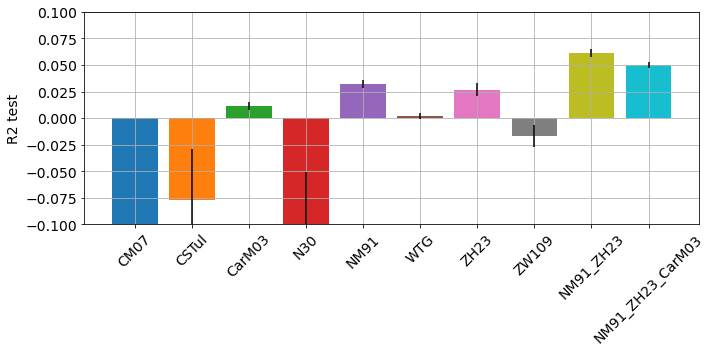

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5), tight_layout=True)

strain_combos = list(STRAINS_UNIQUE) + ['NM91_ZH23', 'NM91_ZH23_CarM03']

for cstrain, strain in enumerate(strain_combos):
    data = load_npy(f'data/simple/mlv/neur_basic/baker_{NRL_MDL}_{strain.lower()}_{TARG.lower()}.npy')
        
    r2_mn = data['r2_test'].mean()
    r2_std = data['r2_test'].std()
    r2_sem = r2_std/np.sqrt(data['nsplit'])

    ax.bar([cstrain], [r2_mn], yerr=[r2_sem])

ax.axhline(0, lw=2, c='k', ls='--')
ax.set_xticks(np.arange(len(strain_combos)))
ax.set_xticklabels(strain_combos, rotation=45)

ax.set_ylabel('R2 test')

ax.set_ylim(-0.1, .1)
ax.grid()

set_plot(ax, font_size=14)